In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt

In [3]:
from argparse import Namespace
from pathlib import Path

import numpy as np

import torch
from torch.utils.data import Dataset, DataLoader

import pytorch_lightning as pl
from pytorch_lightning.trainer import Trainer, seed_everything
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint

from turboflow.datasets.turb2D import Turb2D
from turboflow.evaluation import compute_all_metrics

from turboflow.utils import phy_utils as phy
from turboflow.utils import dsp_utils as dsp
from turboflow.utils import torch_utils as tch
from turboflow.utils import viz_utils as viz 
from turboflow.utils import file_utils as fle

import cmocean

In [4]:
seed_everything(42, workers=True)

Global seed set to 42


42

(256, 256, 2)
(256, 256, 2)


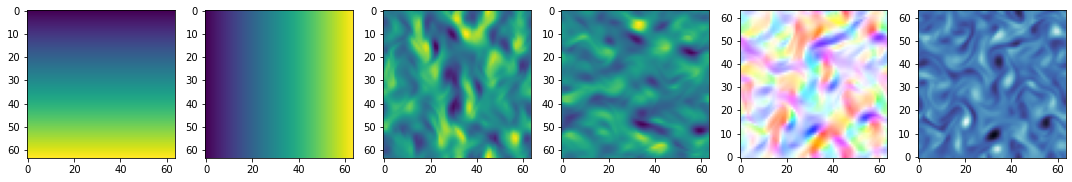

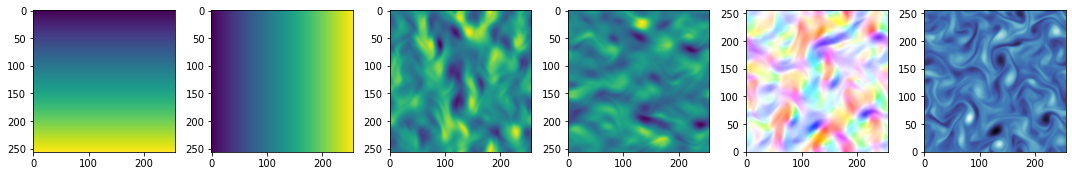

In [5]:
# load dataset
data_dir = Path('/','home','dicarlo_d','Documents','Datasets','Turb2D.hdf5')
tb = Turb2D(data_dir)

time_idx = 862
tb.load_data(time_idx)

# Data in Turb2D are (T,R,R,D)
t = tb.t
xy = tb.xy
uv = tb.uv

print(xy.shape)
print(uv.shape)

# normalize y
uv = uv/np.max(np.abs(uv))
assert np.min(uv) >= -1
assert np.max(uv) <=  1

ds = 4

xy_sq_lr = xy[::ds,::ds,:]
uv_sq_lr = uv[::ds,::ds,:]
xy_sq_hr = xy
uv_sq_hr = uv

data = {
    'ongrid' : {
        'lr' : {'xy' : xy[::ds,::ds,:], 'uv' : uv[::ds,::ds,:], 'R'  : xy[::ds,::ds,:].shape[0]},
        'hr' : {'xy' : xy, 'uv' : uv, 'R'  : xy.shape[0]},
    }
}

for res in ['lr', 'hr']:
    x = data['ongrid'][res]['xy'][...,0]
    y = data['ongrid'][res]['xy'][...,1]
    u = data['ongrid'][res]['uv'][...,0]
    v = data['ongrid'][res]['uv'][...,1]
    
    plt.figure(figsize=(15,5))
    plt.subplot(161)
    plt.imshow(x)
    plt.subplot(162)
    plt.imshow(y)
    plt.subplot(163)
    plt.imshow(u)
    plt.subplot(164)
    plt.imshow(v)
    
    plt.subplot(165)
    img = viz.flow_to_image(data['ongrid'][res]['uv'])
    plt.imshow(img, origin='lower')
    
    plt.subplot(166)
    w = phy.compute_vorticity((x, y), (u, v))
    plt.imshow(w, origin='lower', cmap=cmocean.cm.ice)
    
    plt.tight_layout()
    plt.show()

In [6]:
# increase resolutions
s=2
u_smp, xy_smp = dsp.interpolate2D_mesh01x01(xy, uv[:,:,0], scale=s)
v_smp, xy_smp = dsp.interpolate2D_mesh01x01(xy, uv[:,:,1], scale=s)

print(u_smp.shape)

xy_smp = np.stack([xy_smp[:,:,1], xy_smp[:,:,0]], axis=-1)
uv_smp = np.stack([u_smp, v_smp], axis=-1)


R_smp = uv_smp.shape[0]
xy_smp = xy_smp.reshape(R_smp**2, 2)
uv_smp = uv_smp.reshape(R_smp**2, 2)

uv_smp = uv_smp/np.max(np.abs(uv_smp))
print(np.max(np.abs(xy_smp)))
print(np.max(np.abs(uv_smp)))

print(uv_smp.shape)
print(xy_smp.shape)

(512, 512)
1.0
1.0
(262144, 2)
(262144, 2)


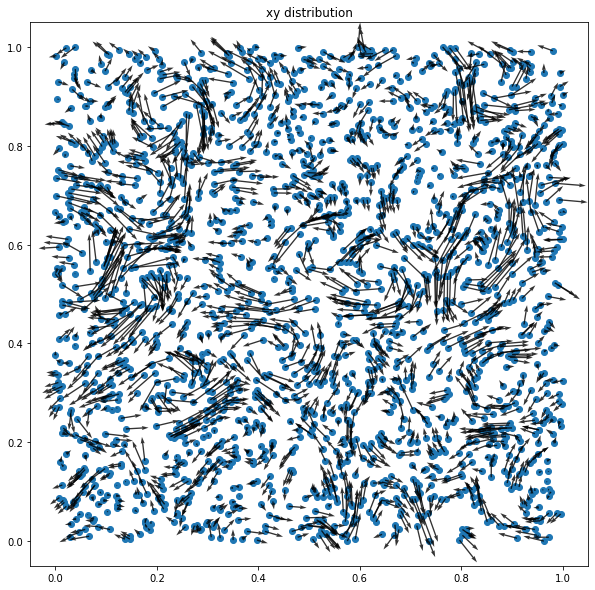

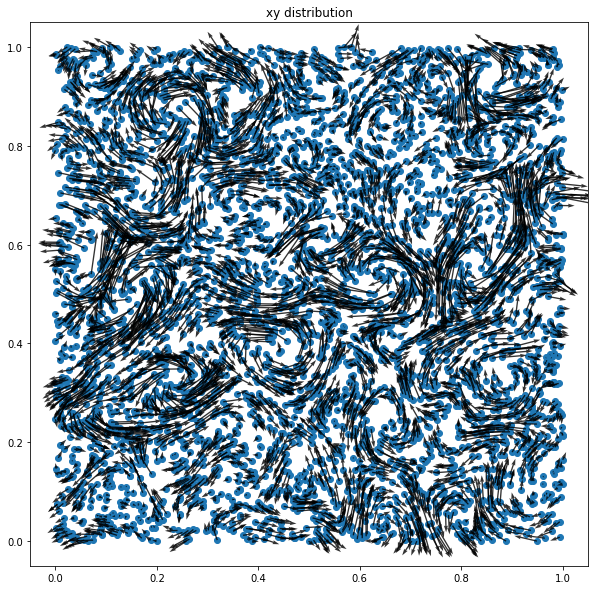

In [7]:
max_res = 256

# subsample for TEST
ppp_test = 0.07
N_test = int((max_res**2) * ppp_test)
idx_test = np.random.randint(0, R_smp**2, size=N_test)

ppp_train = 0.03
N_train = int((max_res**2)*ppp_train)
idx_train = np.random.randint(0, R_smp**2, size=N_train)

data['offgrid'] = {
    'lr' : {'xy' :  xy_smp[idx_train,:], 'uv' : uv_smp[idx_train,:], 'R' : idx_train.shape[0]},
    'hr' : {'xy' :  xy_smp[idx_test,:],  'uv' : uv_smp[idx_test,:],  'R' : idx_test.shape[0]}
}


for res in ['lr', 'hr']:
    x = data['offgrid'][res]['xy'][...,0]
    y = data['offgrid'][res]['xy'][...,1]
    u = data['offgrid'][res]['uv'][...,0]
    v = data['offgrid'][res]['uv'][...,1]
    
    plt.figure(figsize=(10,10))
    plt.title('xy distribution')
    plt.scatter(x, y)
    
    ds = 1
    plt.quiver(x[::ds], y[::ds], u[::ds], v[::ds], scale=10, alpha=0.8)
    plt.show()
    
#     plt.figure(figsize=(10,10))
#     ds = 2
#     plt.quiver(x[::ds], y[::ds], u[::ds], v[::ds], scale=10, color='k')
#     plt.axis('off')
#     plt.show()
    

In [8]:
class MyDataset(torch.utils.data.Dataset):
    'Characterizes a dataset for PyTorch'
    def __init__(self, X, y):

        assert np.max(np.abs(y)) <= 1
        assert np.max(np.abs(X)) <= 1

        'Initialization'
        print('X shape', X.shape)
        print('y shape', y.shape)
        try:
            assert X.shape[0] == y.shape[0]
            assert X.shape[1] == y.shape[1]
        except:
            print('*** Dimension error ***')
            print('X', X.shape)
            print('y', y.shape)
            
        H, Cin = X.shape
        H, Cout = y.shape
        
        # reshape s.t. B = H*W of query points
        X = X.reshape(H, Cin)
        y = y.reshape(H, Cout)
        
        self.size = H
        # convert to torch and add an empty dimension for the batch
        self.inputs = torch.from_numpy(X).float() #XY x 2 (x,y)
        self.target = torch.from_numpy(y).float()  #XxYx3 (RGB)
        
        assert self.inputs.shape[0] == self.target.shape[0]
        assert self.inputs.shape[1] == self.target.shape[1]
        
        print(self.inputs.shape)
        print(self.inputs.shape)

    def __len__(self):
        'Denotes the total number of samples'
        return self.size

    def __getitem__(self, idx):
        'Generates one sample of data'
        # Load data and get label
        X = self.inputs[idx,...]
        y = self.target[idx,...]

        return X, y


class DataModule(pl.LightningDataModule):
    def __init__(self, train_data, val_data, test_data):
        
        super().__init__()
        self.train_data = train_data
        self.test_data = test_data
        self.val_data = val_data
        self.batch_size = 666666
        self.num_workers = 1
        
    def prepare_data(self):
        self.train_dataset = MyDataset(self.train_data[0], self.train_data[1])
        self.val_dataset = MyDataset(self.val_data[0], self.val_data[1])
        self.test_dataset = MyDataset(self.test_data[0], self.test_data[1])
    
    def train_dataloader(self):
        return DataLoader(self.train_dataset, 
                          self.batch_size, num_workers = self.num_workers)

    def val_dataloader(self):
        return DataLoader(self.val_dataset, 
                          self.batch_size, num_workers = self.num_workers)

    def test_dataloader(self):
        return DataLoader(self.test_dataset, 
                          self.batch_size, num_workers = self.num_workers)
    
dm = DataModule(
    train_data=[data['offgrid']['lr']['xy'],
                data['offgrid']['lr']['uv']],
    val_data=[data['offgrid']['lr']['xy'],
              data['offgrid']['lr']['uv']],
    test_data=[data['offgrid']['hr']['xy'],
               data['offgrid']['hr']['uv']],
)

dm.prepare_data()

X shape (1966, 2)
y shape (1966, 2)
torch.Size([1966, 2])
torch.Size([1966, 2])
X shape (1966, 2)
y shape (1966, 2)
torch.Size([1966, 2])
torch.Size([1966, 2])
X shape (4587, 2)
y shape (4587, 2)
torch.Size([4587, 2])
torch.Size([4587, 2])


/home/dicarlo_d/Documents/Code/TurboSuperResultion/venv/lib/python3.8/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:446: UserWarning: Checkpoint directory .torch_checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/home/dicarlo_d/Documents/Code/TurboSuperResultion/venv/lib/python3.8/site-packages/pytorch_lightning/core/datamodule.py:423: LightningDeprecationWarning: DataModule.setup has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.setup.
  rank_zero_deprecation(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type            | Params
--------------------------------------------
0 | rff     | Fourier         | 512   
1 | mlp     | MLP             | 592 K 
2 | div     | DivFree         | 0     
3 | sp_grad | SpatialGradient | 0 

Validation sanity check: 0it [00:00, ?it/s]

/home/dicarlo_d/Documents/Code/TurboSuperResultion/venv/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:105: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 48 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
Global seed set to 42
/home/dicarlo_d/Documents/Code/TurboSuperResultion/venv/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:105: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 48 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/dicarlo_d/Documents/Code/TurboSuperResultion/venv/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:326: UserWarning: The numb

Training: -1it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

/home/dicarlo_d/Documents/Code/TurboSuperResultion/venv/lib/python3.8/site-packages/pytorch_lightning/core/datamodule.py:423: LightningDeprecationWarning: DataModule.teardown has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.teardown.
  rank_zero_deprecation(
/home/dicarlo_d/Documents/Code/TurboSuperResultion/venv/lib/python3.8/site-packages/pytorch_lightning/core/datamodule.py:423: LightningDeprecationWarning: DataModule.setup has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.setup.
  rank_zero_deprecation(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

/home/dicarlo_d/Documents/Code/TurboSuperResultion/venv/lib/python3.8/site-packages/pytorch_lightning/core/datamodule.py:423: LightningDeprecationWarning: DataModule.teardown has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.teardown.
  rank_zero_deprecation(
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/home/dicarlo_d/Documents/Code/TurboSuperResultion/venv/lib/python3.8/site-packages/pytorch_lightning/core/datamodule.py:423: LightningDeprecationWarning: DataModule.setup has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.setup.
  rank_zero_deprecation(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type            | Params
--------------------------------------------
0 | rff     | Fourier         | 512   
1 | mlp     | MLP             | 592 K 
2 | div     | DivFree         | 0     

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test/metrics/angular_degree': 11.523093223571777,
 'test/metrics/reconstruction': 0.07473815232515335}
--------------------------------------------------------------------------------


Validation sanity check: 0it [00:00, ?it/s]

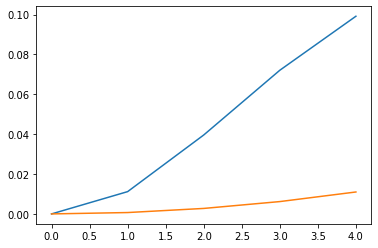

Global seed set to 42
/home/dicarlo_d/Documents/Code/TurboSuperResultion/venv/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:105: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 48 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/dicarlo_d/Documents/Code/TurboSuperResultion/venv/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:326: UserWarning: The number of training samples (1) is smaller than the logging interval Trainer(log_every_n_steps=20). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Training: -1it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

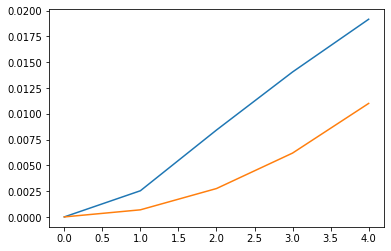

Validating: 0it [00:00, ?it/s]

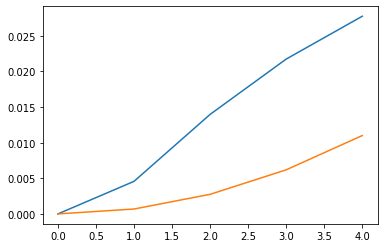

Validating: 0it [00:00, ?it/s]

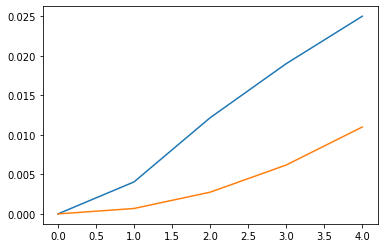

Validating: 0it [00:00, ?it/s]

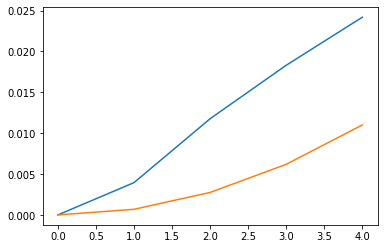

Validating: 0it [00:00, ?it/s]

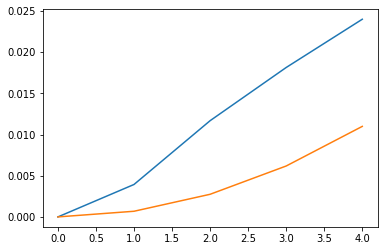

Validating: 0it [00:00, ?it/s]

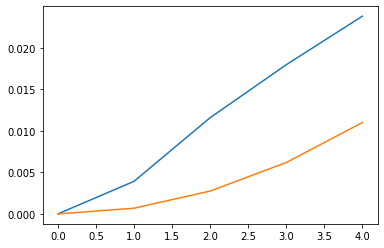

Validating: 0it [00:00, ?it/s]

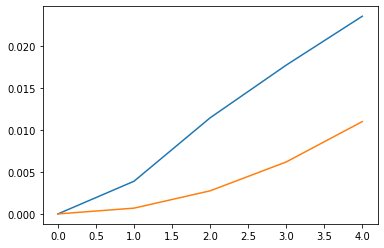

Validating: 0it [00:00, ?it/s]

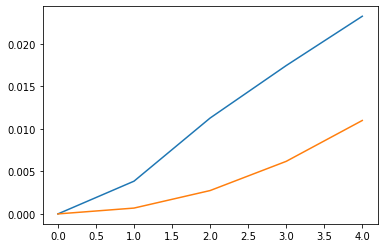

Validating: 0it [00:00, ?it/s]

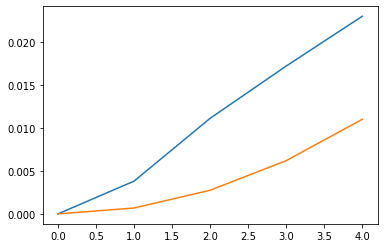

Validating: 0it [00:00, ?it/s]

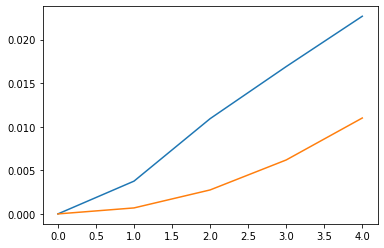

Validating: 0it [00:00, ?it/s]

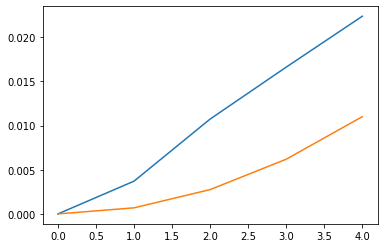

Validating: 0it [00:00, ?it/s]

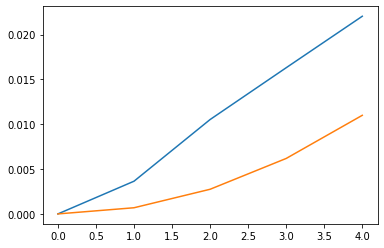

Validating: 0it [00:00, ?it/s]

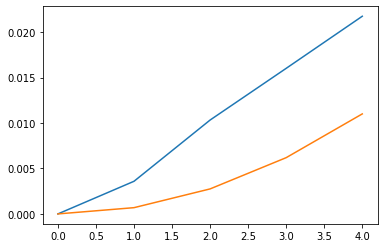

Validating: 0it [00:00, ?it/s]

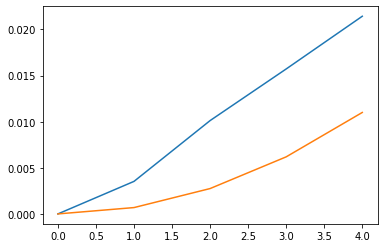

Validating: 0it [00:00, ?it/s]

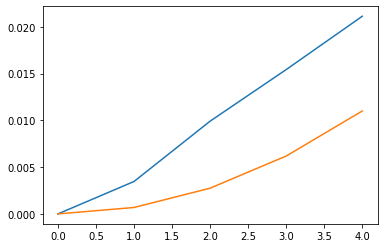

Validating: 0it [00:00, ?it/s]

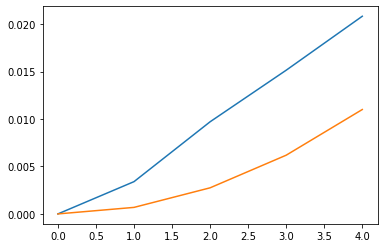

Validating: 0it [00:00, ?it/s]

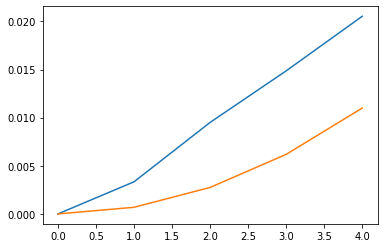

Validating: 0it [00:00, ?it/s]

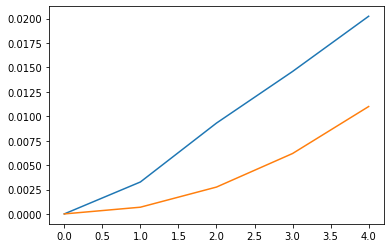

Validating: 0it [00:00, ?it/s]

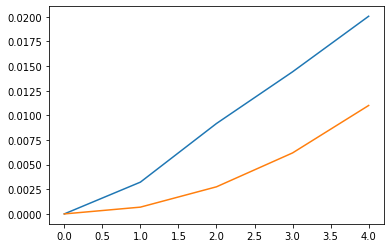

Validating: 0it [00:00, ?it/s]

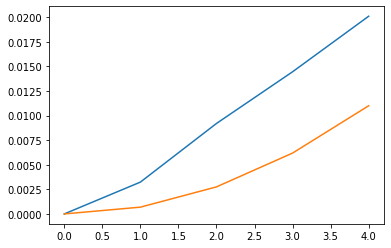

Validating: 0it [00:00, ?it/s]

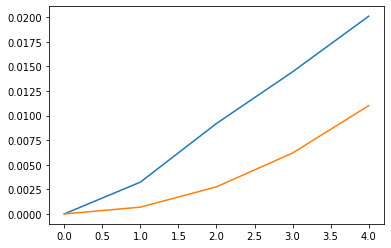

Validating: 0it [00:00, ?it/s]

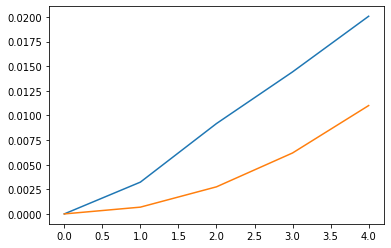

Validating: 0it [00:00, ?it/s]

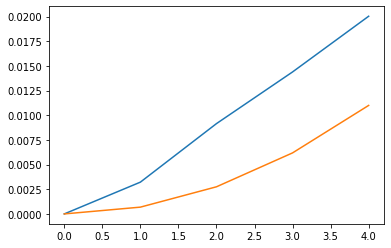

Validating: 0it [00:00, ?it/s]

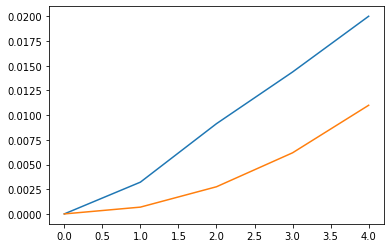

Validating: 0it [00:00, ?it/s]

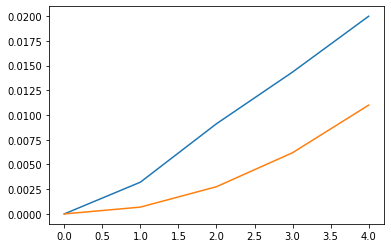

Validating: 0it [00:00, ?it/s]

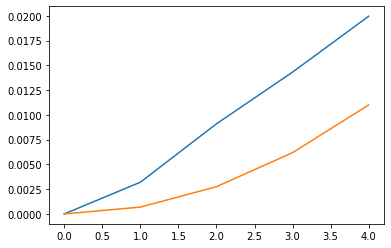

Validating: 0it [00:00, ?it/s]

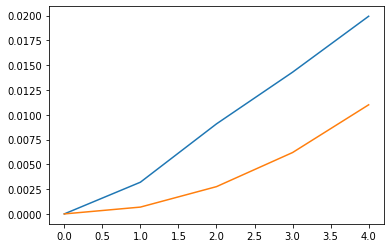

Validating: 0it [00:00, ?it/s]

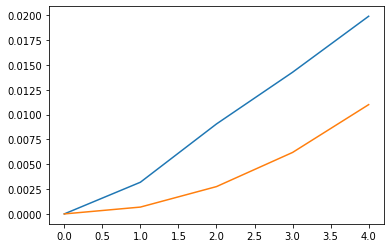

Validating: 0it [00:00, ?it/s]

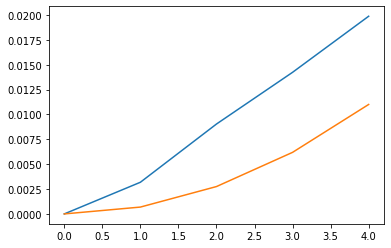

Validating: 0it [00:00, ?it/s]

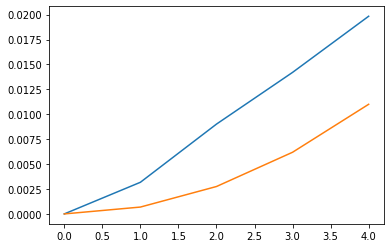

/home/dicarlo_d/Documents/Code/TurboSuperResultion/venv/lib/python3.8/site-packages/pytorch_lightning/core/datamodule.py:423: LightningDeprecationWarning: DataModule.teardown has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.teardown.
  rank_zero_deprecation(
/home/dicarlo_d/Documents/Code/TurboSuperResultion/venv/lib/python3.8/site-packages/pytorch_lightning/core/datamodule.py:423: LightningDeprecationWarning: DataModule.setup has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.setup.
  rank_zero_deprecation(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/dicarlo_d/Documents/Code/TurboSuperResultion/venv/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:105: UserWarning: The dataloader, test dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 48 which is

Testing: 0it [00:00, ?it/s]

/home/dicarlo_d/Documents/Code/TurboSuperResultion/venv/lib/python3.8/site-packages/pytorch_lightning/core/datamodule.py:423: LightningDeprecationWarning: DataModule.teardown has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.teardown.
  rank_zero_deprecation(
/home/dicarlo_d/Documents/Code/TurboSuperResultion/venv/lib/python3.8/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:446: UserWarning: Checkpoint directory .torch_checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/home/dicarlo_d/Documents/Code/TurboSuperResultion/venv/lib/python3.8/site-packages/pytorch_lightning/core/datamodule.py:423: LightningDeprecationWarning: DataModule.setup has already been called, so it will not be called again. In v1.6 this behavior will change to always

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test/metrics/angular_degree': 9.070268630981445,
 'test/metrics/reconstruction': 0.04708719253540039}
--------------------------------------------------------------------------------


Validation sanity check: 0it [00:00, ?it/s]

/home/dicarlo_d/Documents/Code/TurboSuperResultion/venv/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:105: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 48 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


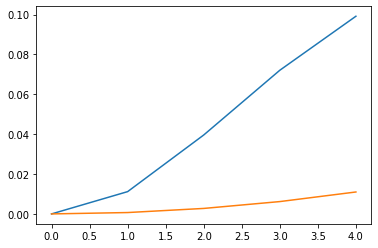

Global seed set to 42
/home/dicarlo_d/Documents/Code/TurboSuperResultion/venv/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:105: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 48 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/dicarlo_d/Documents/Code/TurboSuperResultion/venv/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:326: UserWarning: The number of training samples (1) is smaller than the logging interval Trainer(log_every_n_steps=20). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Training: -1it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

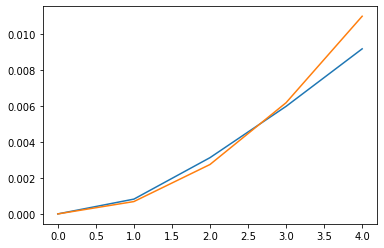

Validating: 0it [00:00, ?it/s]

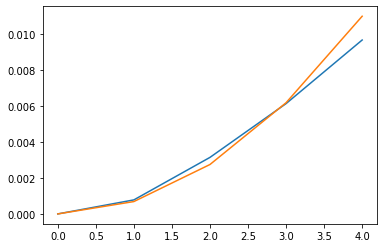

Validating: 0it [00:00, ?it/s]

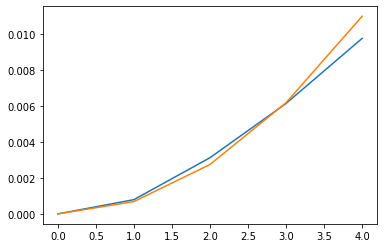

Validating: 0it [00:00, ?it/s]

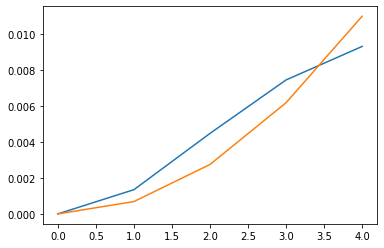

Validating: 0it [00:00, ?it/s]

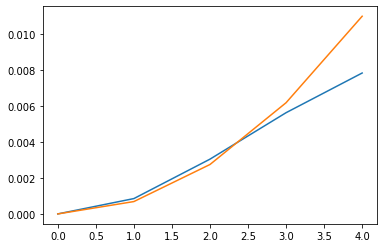

Validating: 0it [00:00, ?it/s]

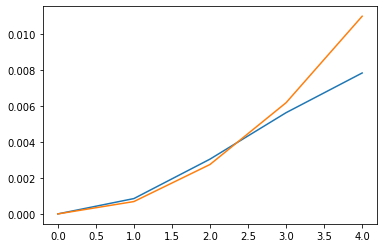

/home/dicarlo_d/Documents/Code/TurboSuperResultion/venv/lib/python3.8/site-packages/pytorch_lightning/core/datamodule.py:423: LightningDeprecationWarning: DataModule.teardown has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.teardown.
  rank_zero_deprecation(
/home/dicarlo_d/Documents/Code/TurboSuperResultion/venv/lib/python3.8/site-packages/pytorch_lightning/core/datamodule.py:423: LightningDeprecationWarning: DataModule.setup has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.setup.
  rank_zero_deprecation(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/dicarlo_d/Documents/Code/TurboSuperResultion/venv/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:105: UserWarning: The dataloader, test dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 48 which is

Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test/metrics/angular_degree': 16.57492446899414,
 'test/metrics/reconstruction': 0.11920478940010071}
--------------------------------------------------------------------------------


/home/dicarlo_d/Documents/Code/TurboSuperResultion/venv/lib/python3.8/site-packages/pytorch_lightning/core/datamodule.py:423: LightningDeprecationWarning: DataModule.teardown has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.teardown.
  rank_zero_deprecation(


In [15]:
for df in [True]:
    
    for sdiv in [0]:
        
        for sfun in [0, 1e-3, 1e-1]:

            from turboflow.models.phyrff_hard import plDivFreeRFFNet

            # choose the hyperparams
            hparams = {
                'name':'RFFNet',
                'mlp_layers_num': 8,
                'mlp_layers_dim': 256, 
                'mlp_last_actfn': 'tanh',
                'do_rff': True, 
                'rff_num': 256, 
                'rff_scale': 10,
                'do_divfree': df,
                'lam_sdiv': sdiv,     # spatial grad(u,v) = torch.autograd(u,v)
                'lam_sfn':  sfun,     # offgrid L2 reg. on Sfun
                'lam_spec': 0,    # L2 diff on the spectrum
                'lam_grads':0,    # offrgid L2 reg. on grad and autograd
                'lam_curl' :0,       # smooth grad of vorticity
                'lam_pde' : 0,
                'lam_weight': 1e-3,  # L2 reg on the NN's weights
                'sfn_min_x': 1./256., # maximal resolution
                'sfn_num_centers': 32,
                'sfn_num_increments':5,
                'sfn_patch_dim': 16 # (P/2)
            }

            model = plDivFreeRFFNet(**vars(Namespace(**hparams)))

            early_stop_callback = EarlyStopping(monitor='val/loss/tot')
            checkpoint_callback = ModelCheckpoint(
                monitor="val/loss/tot",
                dirpath=".torch_checkpoints",
                filename="Turb2D-%s-{epoch:02d}-{val_loss:.4f}" % (hparams['name']),
                save_top_k=1,
                mode="min",
            )

            trainer = Trainer(gpus=1,
                              max_epochs=1500, 
                              log_every_n_steps=20,
                              check_val_every_n_epoch=50, 
                              callbacks=[early_stop_callback,
                                         checkpoint_callback])

            trainer.fit(model, dm)

            perf = trainer.test(model, dm)
            path = checkpoint_callback.best_model_path
            vers =  f'version_{trainer.logger.version}'
            res_dict = {
                'metrics' : perf,
                'path' : path,
                'hparams' : hparams,
                'pl_version' : vers,
            }


            out_file = 'lxlaser2022/Turb2D_%s.pkl' % vers
            fle.save_obj(res_dict, out_file)

In [11]:
perf = trainer.test(model, dm)
path = checkpoint_callback.best_model_path
vers =  f'version_{trainer.logger.version}'
res_dict = {
    'metrics' : perf,
    'path' : path,
    'hparams' : hparams,
    'pl_version' : vers,
}


out_file = 'lxlaser2022/Turb2D_%s.pkl' % vers
fle.save_obj(res_dict, out_file)

/home/dicarlo_d/Documents/Code/TurboSuperResultion/venv/lib/python3.8/site-packages/pytorch_lightning/core/datamodule.py:423: LightningDeprecationWarning: DataModule.setup has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.setup.
  rank_zero_deprecation(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test/metrics/angular_degree': 8.828313827514648,
 'test/metrics/reconstruction': 0.04105118289589882}
--------------------------------------------------------------------------------


/home/dicarlo_d/Documents/Code/TurboSuperResultion/venv/lib/python3.8/site-packages/pytorch_lightning/core/datamodule.py:423: LightningDeprecationWarning: DataModule.teardown has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.teardown.
  rank_zero_deprecation(


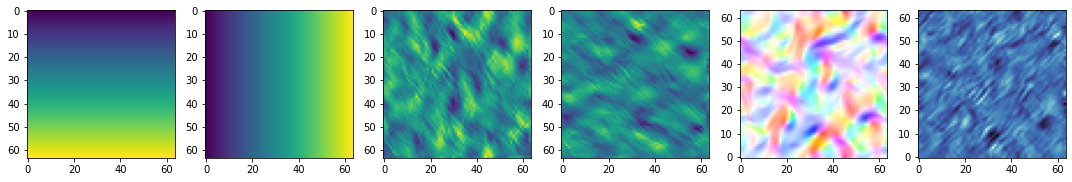

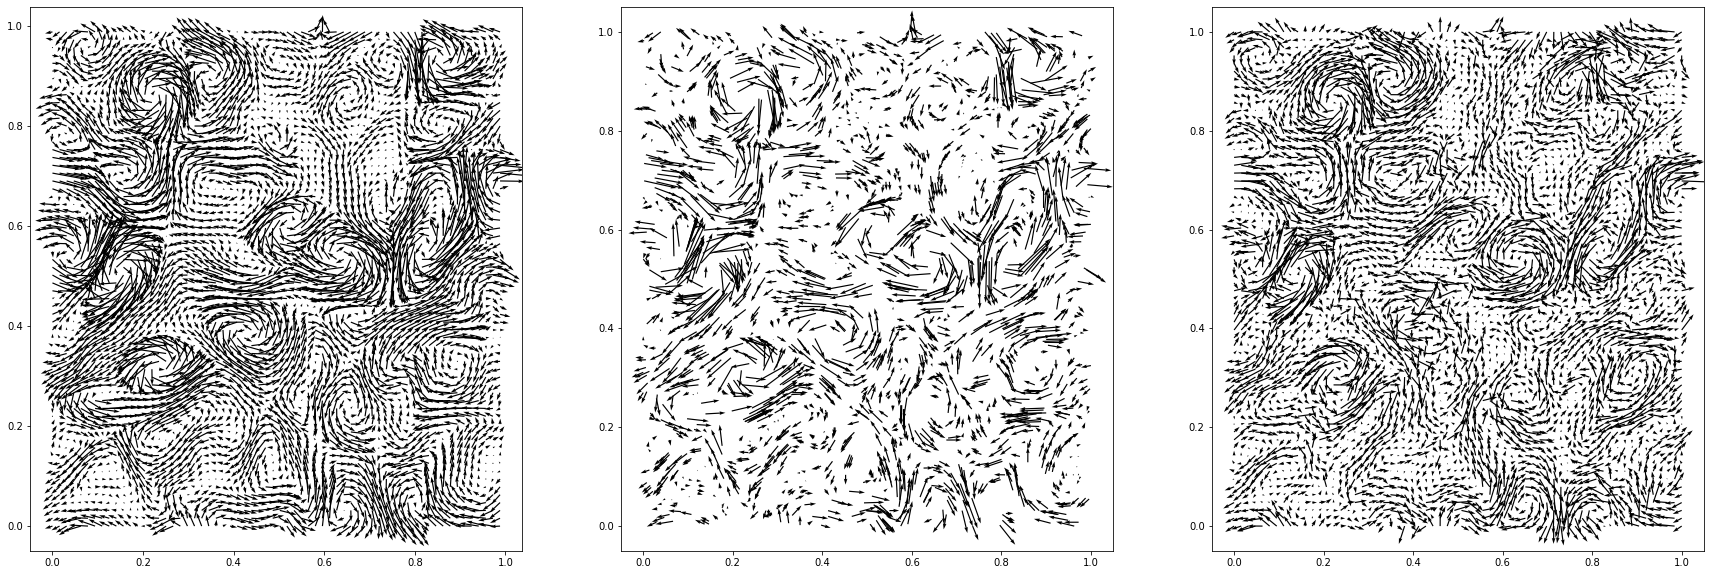

In [12]:
res = 'lr'
R = data['ongrid'][res]['R']
patch_ln = torch.linspace(0, 1, R)
# make it square meshgrid
patch_sq = torch.stack(torch.meshgrid(patch_ln, patch_ln), dim=-1)

xy = patch_sq.view(-1,2)
uv = model(xy)[0]

x = xy.reshape(R,R,2).detach().cpu().numpy()[:,:,0]
y = xy.reshape(R,R,2).detach().cpu().numpy()[:,:,1]
u = uv.reshape(R,R,2).detach().cpu().numpy()[:,:,0]
v = uv.reshape(R,R,2).detach().cpu().numpy()[:,:,1]

plt.figure(figsize=(15,5))
plt.subplot(161)
plt.imshow(x)
plt.subplot(162)
plt.imshow(y)
plt.subplot(163)
plt.imshow(u)
plt.subplot(164)
plt.imshow(v)
plt.subplot(165)
img = viz.flow_to_image(data['ongrid'][res]['uv'])
plt.imshow(img, origin='lower')
plt.subplot(166)
w = phy.compute_vorticity((x, y), (u, v))
plt.imshow(w, origin='lower', cmap=cmocean.cm.ice)
plt.tight_layout()
plt.show()

s = 1
plt.figure(figsize=(30,10))
plt.subplot(131)
plt.quiver(data['ongrid'][res]['xy'][::s,::s, 0], 
           data['ongrid'][res]['xy'][::s,::s, 1],
           data['ongrid'][res]['uv'][::s,::s, 0],
           data['ongrid'][res]['uv'][::s,::s, 1], scale=10)
plt.subplot(132)
plt.quiver(data['offgrid'][res]['xy'][::s, 0], 
           data['offgrid'][res]['xy'][::s, 1],
           data['offgrid'][res]['uv'][::s, 0],
           data['offgrid'][res]['uv'][::s, 1], scale=10)
plt.subplot(133)
plt.quiver(x[::s,::s], y[::s,::s],
           u[::s,::s], v[::s,::s], scale=10)

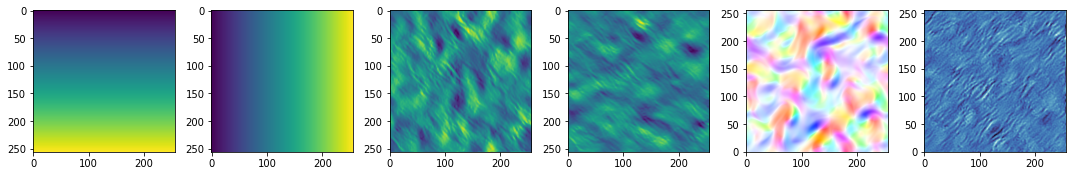

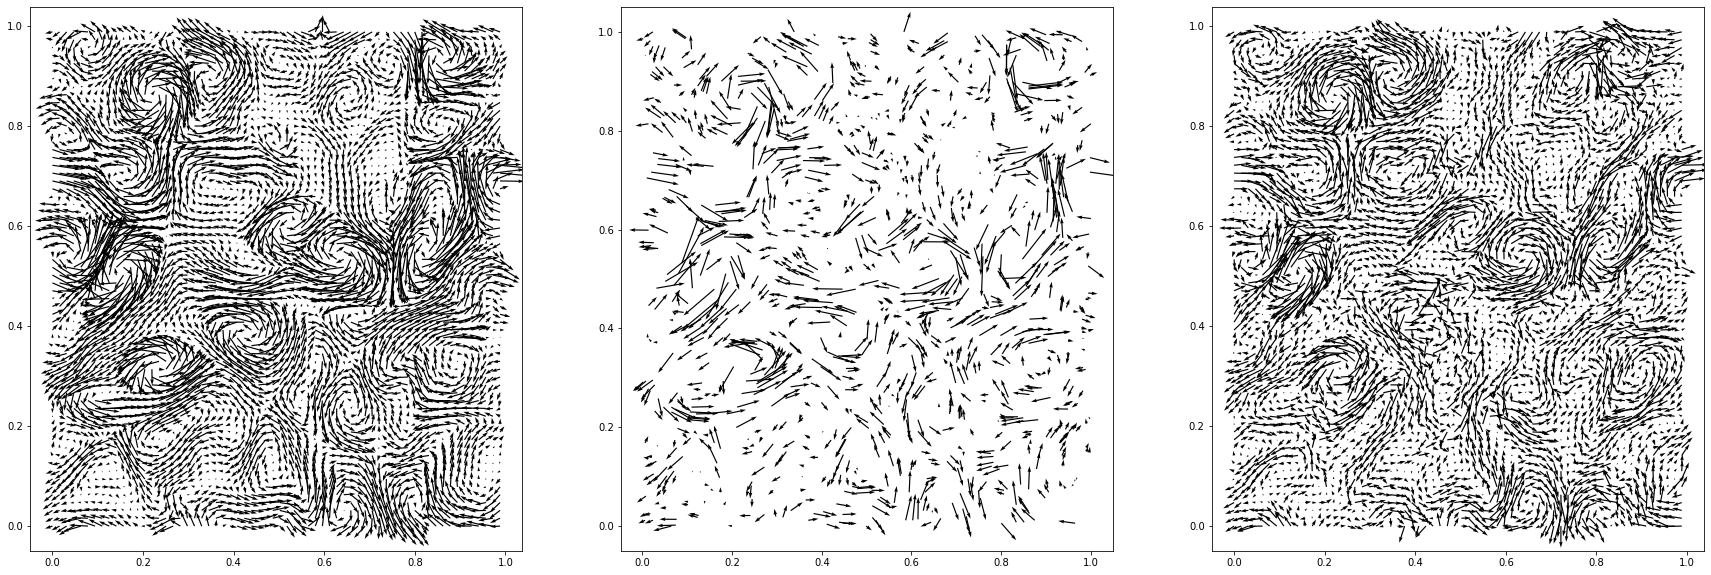

In [13]:
res = 'hr'
R = data['ongrid'][res]['R']
patch_ln = torch.linspace(0, 1, R)
# make it square meshgrid
patch_sq = torch.stack(torch.meshgrid(patch_ln, patch_ln), dim=-1)

xy = patch_sq.view(-1,2)
uv = model(xy)[0]

x = xy.reshape(R,R,2).detach().cpu().numpy()[:,:,0]
y = xy.reshape(R,R,2).detach().cpu().numpy()[:,:,1]
u = uv.reshape(R,R,2).detach().cpu().numpy()[:,:,0]
v = uv.reshape(R,R,2).detach().cpu().numpy()[:,:,1]

plt.figure(figsize=(15,5))
plt.subplot(161)
plt.imshow(x)
plt.subplot(162)
plt.imshow(y)
plt.subplot(163)
plt.imshow(u)
plt.subplot(164)
plt.imshow(v)
plt.subplot(165)
img = viz.flow_to_image(data['ongrid'][res]['uv'])
plt.imshow(img, origin='lower')
plt.subplot(166)
w = phy.compute_vorticity((x, y), (u, v))
plt.imshow(w, origin='lower', cmap=cmocean.cm.ice)
plt.tight_layout()
plt.show()

s = 4
plt.figure(figsize=(30,10))
plt.subplot(131)
plt.quiver(data['ongrid'][res]['xy'][::s,::s, 0], 
           data['ongrid'][res]['xy'][::s,::s, 1],
           data['ongrid'][res]['uv'][::s,::s, 0],
           data['ongrid'][res]['uv'][::s,::s, 1], scale=10)
plt.subplot(132)
plt.quiver(data['offgrid'][res]['xy'][::s, 0], 
           data['offgrid'][res]['xy'][::s, 1],
           data['offgrid'][res]['uv'][::s, 0],
           data['offgrid'][res]['uv'][::s, 1], scale=10)
plt.subplot(133)
plt.quiver(x[::s,::s], y[::s,::s],
           u[::s,::s], v[::s,::s], scale=10)

# plt.figure(figsize=(10,10))
# plt.quiver(x[::s,::s], y[::s,::s],
#            u[::s,::s], v[::s,::s], scale=10)
# plt.axis('off')
# plt.show()

In [ ]:
print('Error')
res = 'hr'
R = data['ongrid'][res]['R']
xy = torch.Tensor(data['ongrid'][res]['xy']).view(-1,2)
uv = model(xy)[0]
print(uv.shape)

uv_err = uv.reshape(R,R,2).detach().cpu().numpy() - data['ongrid'][res]['uv']
mag = np.sqrt(uv_err**2).sum(-1)

s = 2
plt.figure(figsize=(8,8))
plt.quiver(xy[:,0].reshape(R,R).detach().cpu()[::s,::s], 
           xy[:,1].reshape(R,R).detach().cpu()[::s,::s],
           uv_err[::s,::s,0],
           uv_err[::s,::s,1], mag[::s,::s], scale=10)
plt.show()

In [ ]:
checkpoint_callback.best_model_path

In [ ]:
# grads = '/home/dicarlo_d/Documents/Code/TurboSuperResultion/notebooks/.torch_checkpoints/Turb2D-RFFNet-epoch=1019-val_loss=0.01.ckpt'

In [ ]:
# compute spectrum
spec_ns = phy.energy_spectrum(torch.randn([256,256,2]).permute(2,0,1))[0]
spec_lr = phy.energy_spectrum(torch.Tensor(data['ongrid']['lr']['uv']).permute(2,0,1))[0]
spec_hr = phy.energy_spectrum(torch.Tensor(data['ongrid']['hr']['uv']).permute(2,0,1))[0]

res = 'lr'
R = data['ongrid'][res]['R']
xy = torch.Tensor(data['ongrid'][res]['xy']).view(-1,2)
uv = model(xy)[0]
print(uv.shape)
spec_lr_pred = phy.energy_spectrum(uv.view(R,R,2).permute(2,0,1))[0]


res = 'hr'
R = data['ongrid'][res]['R']
xy = torch.Tensor(data['ongrid'][res]['xy']).view(-1,2)
uv = model(xy)[0]
print(uv.shape)
spec_hr_pred = phy.energy_spectrum(uv.view(R,R,2).permute(2,0,1))[0]

plt.loglog(spec_lr, label='lr gt')
plt.loglog(spec_hr, label='hr gt')
plt.loglog(spec_lr_pred.detach(), label='lr pred')
plt.loglog(spec_hr_pred.detach(), label='hr pred')
plt.legend()
plt.show()

In [53]:
from scipy import interpolate

def interpolate2D_mesh01x01(xy, z, npoints):

    assert xy.shape[1] == 2

    x = xy[:,0]
    y = xy[:,1]
    z = z

    f_interp2d = interpolate.interp2d(x, y, z, kind='linear') # 'cubic'

    x = np.linspace(0, 1, npoints, endpoint=True)
    y = np.linspace(0, 1, npoints, endpoint=True)
#     xy = np.stack(np.meshgrid(x, y), axis=-1).reshape(npoints*npoints,2)
#     x = xy[:,0]
#     y = xy[:,1]

    return f_interp2d(x, y)

In [67]:
Ulr = data['ongrid']['lr']['xy']
Uhr = data['ongrid']['hr']['xy']

xy = data['offgrid']['lr']['xy']
uv = data['offgrid']['lr']['uv']
u_smp_lr = interpolate2D_mesh01x01(xy, uv[:,0], npoints=128)
v_smp_lr = interpolate2D_mesh01x01(xy, uv[:,1], npoints=128)
Ulr_pred = np.stack([u_smp_lr, v_smp_lr], axis=-1)

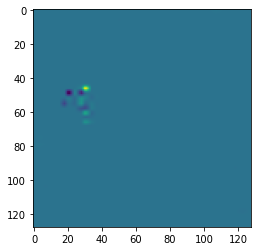

In [68]:
plt.imshow(Ulr_pred[:,:,0])

In [64]:
import turboflow.evaluation as evl

err_lr = evl.recostruction_error(torch.Tensor(Ulr_pred).contiguous().view(-1,2), 
                                 torch.Tensor(Ulr).contiguous().view(-1,2))
ang_lr = evl.angular_error_2Dfield(torch.Tensor(Ulr_pred).contiguous().view(-1,2), 
                                   torch.Tensor(Ulr).contiguous().view(-1,2))

print(err_lr.item(), ang_lr.item())

17028334.0 51.94619369506836


In [ ]:
u_smp_mr = interpolate2D_mesh01x01(xy, uv[:,0], npoints=128)[0]
v_smp_mr = interpolate2D_mesh01x01(xy, uv[:,1], npoints=128)[0]
Umr = np.stack([u_smp_mr, v_smp_mr], axis=-1)